# Relevant information from work on ARID1A

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


# Looking at ARID1A Interacting Proteins, transcript levels

#### GET CPTAC DATA

In [2]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()
transcriptomics_columns = CPTAC.get_transcriptomics_cols()

#### Create a list of interacting proteins (via uniprot and string)

In [3]:
#List of some of known interacting proteins
siteList = ['CTCF','RUNX1','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2','PTEN']

### Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [4]:
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    if site in transcriptomics_columns:
        transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
        '''Look only at Tumor patients'''
        transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
        #print(transdf)
        wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
        mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
        ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
        p_values.append(ttest[1])
        site_names.append(site)
        
'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(site_names)

significantSites = []
significantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])

In [5]:
#Print off significant sites
print(significantSites)

['TP53']


In [6]:
bfSignificantVals = dict(zip(significantSites, significantPvals))
print(bfSignificantVals)

{'TP53': 0.00037328494313790787}


#### Plot significant sites, mutated vs wildtype

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation')]

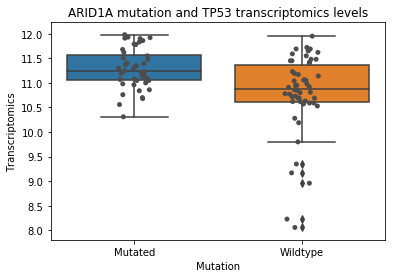

In [7]:
gene = "ARID1A"
site = "TP53"

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)


for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")

#### Plot significant sites, look at all mutations

[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation Type')]

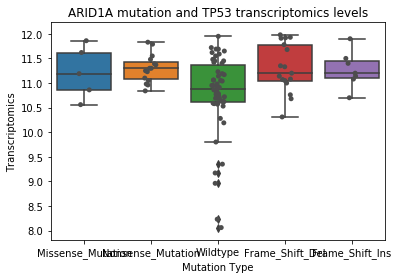

In [8]:
genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation Type",ylabel="Transcriptomics")

### Only TP53 Showed significant change in transcript levels when ARID1A Mutated

TP53 transcription may be affected by ARID1A Mutation. None of the other interacting proteins' transcript levels seem to be affected by ARID1A Mutation

# Look at ARID1A Mutation effect on all proteins transcript levels

In [9]:
'''Looking at all proteins transcription levels'''
siteList = transcriptomics_columns

p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
    #print(transdf)
    wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
    mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
    ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
    p_values.append(ttest[1])
    site_names.append(site)

'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(siteList)

significantSites = []
significantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])

## Print all statistically significant proteins, their corresponding p-value

In [10]:
'''Make a dict of sites-p-values'''
bfSignificantVals = dict(zip(significantSites, significantPvals))

'''Print off significant sites with their corresponding p-value'''
for key, value in bfSignificantVals.items():
    print(key, "  :  ", value)

ANKRD37   :   1.7382368580878786e-06
BBC3   :   1.7649686039222225e-06
C2CD6   :   4.904323670083253e-07
CCDC36   :   1.7370280109802984e-06
CTSF   :   5.004872090053127e-07
DIRC3   :   5.690524992737917e-07
EYA4   :   5.12192988107089e-08
FAM110B   :   4.2599642455274165e-07
FAM57A   :   2.793435694200713e-08
HSPB6   :   5.727551742121599e-07
LHCGR   :   8.169737411299089e-07
LOC100507351   :   3.71096828724175e-07
LRBA   :   2.1295076932123176e-07
LRRC8E   :   1.555704091002909e-06
MAB21L2   :   1.2952573456275043e-06
MSANTD3   :   3.628535030978892e-07
PCLAF   :   1.0496408425712146e-07
PRNP   :   5.450613377924607e-09
RPS6KA6   :   1.1259974364367532e-06
SAPCD2   :   9.569022650462823e-08
SCN2A   :   1.1402145813064971e-06
TDRD10   :   3.704371564919246e-07
TUB   :   1.7219255954793473e-06
TUBG1   :   1.0811947525318252e-06
WDR34   :   4.5495651944508407e-07
ZDHHC15   :   1.4197409308935562e-06
ZNF208   :   1.0265615688073628e-06
ZNF229   :   7.486431905029763e-07
ZNF663P   :   1.7

### Show most significant value

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation')]

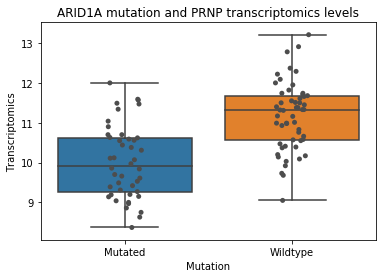

In [11]:
gene = "ARID1A"
site = "PRNP"

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)


for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")

[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation Type')]

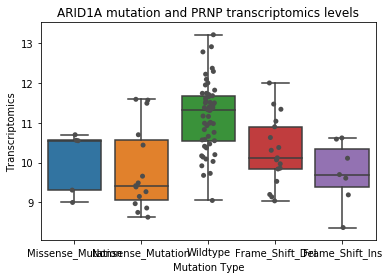

In [12]:
genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation Type",ylabel="Transcriptomics")

### Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [14]:
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
    #print(transdf)
    wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
    mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
    ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
    if not np.isnan(ttest[1]):
        p_values.append(ttest[1])
        site_names.append(site)

## Get the top N most significant

In [15]:
orig_sorted_dict = {}
N = 1500

pvalDict = dict(zip(site_names,p_values))
orig_sorted_dict = dict(sorted(pvalDict.items(), key=lambda kv: kv[1])[:N])


orig_sorted_dict = orig_sorted_dict
print(orig_sorted_dict)

{'PRNP': 5.450613377924607e-09, 'FAM57A': 2.793435694200713e-08, 'EYA4': 5.12192988107089e-08, 'SAPCD2': 9.569022650462823e-08, 'PCLAF': 1.0496408425712146e-07, 'LRBA': 2.1295076932123176e-07, 'ZSCAN12': 2.7217708460424223e-07, 'MSANTD3': 3.628535030978892e-07, 'TDRD10': 3.704371564919246e-07, 'LOC100507351': 3.71096828724175e-07, 'FAM110B': 4.2599642455274165e-07, 'WDR34': 4.5495651944508407e-07, 'C2CD6': 4.904323670083253e-07, 'CTSF': 5.004872090053127e-07, 'DIRC3': 5.690524992737917e-07, 'HSPB6': 5.727551742121599e-07, 'ZNF229': 7.486431905029763e-07, 'LHCGR': 8.169737411299089e-07, 'ZNF208': 1.0265615688073628e-06, 'TUBG1': 1.0811947525318252e-06, 'RPS6KA6': 1.1259974364367532e-06, 'SCN2A': 1.1402145813064971e-06, 'MAB21L2': 1.2952573456275043e-06, 'ZDHHC15': 1.4197409308935562e-06, 'LRRC8E': 1.555704091002909e-06, 'ZNF663P': 1.71455768883987e-06, 'TUB': 1.7219255954793473e-06, 'CCDC36': 1.7370280109802984e-06, 'ANKRD37': 1.7382368580878786e-06, 'BBC3': 1.7649686039222225e-06, 'SNH

### Find the mean difference for each of these N most significant proteins (take mean of mutated, subtract mean of wildtype)

In [18]:
gene = "ARID1A"
diffMeans = []
for val in orig_sorted_dict:
    df = CPTAC.compare_mutations(transcriptomics, val, gene)
    df = df.loc[df["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
    #print(df)
    mutatedf = df.loc[df["Mutation"]!="Wildtype"]
    wtdf= df.loc[df["Mutation"] =="Wildtype"]
    meanMutated = np.mean(mutatedf[val])
    #print("MEAN MUT: ", meanMutated)
    meanWt = np.mean(wtdf[val])
    #print("MEAN WT: ", meanWt)
    diffMean = meanMutated - meanWt
    #print("Diff mean: ", diffMean)
    diffMeans.append(diffMean)
    

pvals = []
for item in orig_sorted_dict:
    pvals.append(-1 * np.log10(orig_sorted_dict[item]))
    #_values.append(item[1])

pvalsAndMeanDiffDict = dict(zip(diffMeans, pvals))
print(pvalsAndMeanDiffDict)

{-1.1466582491582482: 8.263554622189655, 0.6989309764309724: 7.553861321789134, -2.546860269360269: 7.2905663712936795, 1.1018939393939426: 7.01913241741506, 0.870968013468012: 6.9789592788085395, 0.4461531986531959: 6.671720786623985, -0.567196969696969: 6.565148442133647, 0.34398989898989996: 6.44026867975141, -1.2497138047138057: 6.431285458139986, -1.9676094276094238: 6.430512756978288, -1.4401936026936015: 6.370594045975992, 0.5712878787878797: 6.342030107227262, -1.4003114478114451: 6.309420875460995, -1.1612289562289533: 6.300607017344294, -1.3129208754208737: 6.24484766489994, -1.5427693602693573: 6.242030978748536, -1.5816329966329992: 6.125725121309188, -1.6194107744107749: 6.087791902177074, -1.4263888888888872: 5.988614998371876, 0.4779461279461312: 5.966096070772057, -1.270942760942761: 5.948462598243678, -2.101851851851851: 5.943013409446201, 0.41382154882154687: 5.8876439360750465, -0.8852946127946124: 5.847790896848035, 0.6355471380471354: 5.808073006231835, -1.84510942

In [19]:
df = pd.DataFrame({'-Log10(p-value)': pvals, 'Mean Difference':diffMeans})
#print(df)
bonferroniCutoff= 1.7820864668353709e-06
cutoffLine = (-1* np.log10(bonferroniCutoff))

## Plot the mean difference (for top 1500 proteins) against the -log10(p-value) for each protein

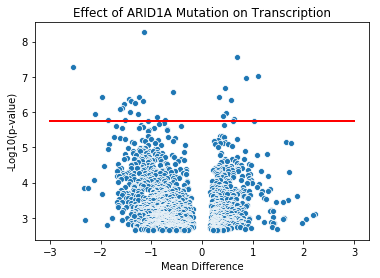

In [20]:
ax = sns.scatterplot(x = "Mean Difference", y = "-Log10(p-value)", data =df)
ax.set_title("Effect of ARID1A Mutation on Transcription")
ax.plot([-3,3],[cutoffLine,cutoffLine], linewidth=2, color="red")